# Art by gan

In this Notebook, we will build a Generative Adversarial Network  (GAN) to illustrate the workings of a Generative Adversarial Network and to generate images. Generative modelling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data. As GANs work by identifying the patterns in the data, we will be using oil painted portraits. However, glancing over the dataset gives me an idea that it is going to be a long shot. The orientation and poses in the dataset vary vastly. Keeping that in mind we are still willing to give it a try. Only because portraits are our jam. We basically love oil painted portraits. 

In [3]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Reshape,
    UpSampling2D,
    Conv2D,
    BatchNormalization,
)
from tensorflow.keras.layers import (
    LeakyReLU,
    Dropout,
    ZeroPadding2D,
    Flatten,
    Activation,
)
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings("ignore")
# Settings
sns.set(rc={"axes.facecolor": "#EDE9DE", "figure.facecolor": "#D8CA7E"})

## Data loading & Prepreprocessing

For this project, We are using .jpg files of images of portraits. The dataset includes various artists. We are loading data as TensorFlow.Dataset, with a batch size of 64. We have reduced the image size to (64,64), presuming, it will be computationally less taxing on the GPU.

## Loading the data

In [4]:
import os
import requests
import zipfile
directory = "./tmp/Portraits"  
zip_url = "https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/Gan/Portraits.zip"
os.makedirs(directory, exist_ok=True)

response = requests.get(zip_url)
zip_filename = os.path.join(directory, "Portraits.zip")

with open(zip_filename, "wb") as file:
    file.write(response.content)
print("ZIP File successfully downloaded")

with zipfile.ZipFile(zip_filename, "r") as zip_ref:
    zip_ref.extractall(directory)

print("ZIP File successfully unzipped")
os.remove(zip_filename)

ZIP File successfully downloaded
ZIP File successfully unzipped


In [5]:
# Importing data
data_path = "./tmp/Portraits"
batch_s = 64
# Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, label_mode=None, image_size=(64, 64), batch_size=16
)

Found 4117 files belonging to 1 classes.


Now that we have the dataset loaded, let us have a look at a few images.

In [6]:
# Defing a function to see images
def Show_Img(data):
    plt.figure(figsize=(15, 15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

Most of the images are portraits. A portrait is a painting representation of a person, The face is predominantly depicted portraits along with expressions and postures. To represent the personality of the subject. Since our model is relative a smaller GAN we have reduced the size of the image. 

## Preprocessing the data

**Normalization:** For the data normalization, we will convert the data in the range between 0 to 1. This helps in fast convergence and makes it easy for the computer to do calculations faster. 
Each of the three RGB channels in the image can take pixel values ranging from 0 to 256. Dividing it by 255 converts it to a range between 0 to 1.

In [7]:
# Preprocessing the dataset for model
data = data.map(lambda x: x / 255.0)
data

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

Now the data is up as a tensorflow Dataset object and is Prepocessed. Next up is building the GAN. 

## Building GAN

GANs employs deep learning methods. It is a dexterous way of posing the problem as a supervised learning problem. It is composed of two models namely Generator and a Discriminator.

Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look like the dataset while a discriminator ("the art critic") learns to tell real images apart from fakes.

During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.

**In this section we will be:**
* Building a Generator
* Building a Discriminator

## The generator

The Generator is a neural network that generates the images. It takes in a random noise as seed and outputs sample data. As the GAN's training progresses the Generator output becomes more and more like the training set, as the Generator tries to improve the output so that the discrimination passes the output as a real image. 

**Following steps are involved in the models building**

* Initialising the Model
* Defining by adding layers

## Building a generator

In [8]:
latent_dim = 100
g_resolution = 2

# Building a Generator
generator = Sequential()
generator.add(Dense(4 * 4 * 256, activation="relu", input_dim=latent_dim))
generator.add(Reshape((4, 4, 256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256, kernel_size=3, padding="same"))  #
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3, kernel_size=3, padding="same"))
generator.add(Activation("tanh"))

generator.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 8, 8, 256)         0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization (Batch  (None, 8, 8, 256)         1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 8, 8, 256)        

Now that the Generator is framed, let us see what random output our untrained Generator produces to get an idea of the process. 

In [9]:
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False)
Generated_Portrait = np.squeeze(Generated_Portrait, axis=0)


Generated_Portrait = np.clip(Generated_Portrait, 0, 1)

Clearly, the output is a random seed containing noise as the Generator is not trained yet. 

## The discriminator

In GANs the Generator works along with the Discriminator. 

The Discriminator network decided whether the data is fake aka created by the Generator or real i.e. from the original input data. To do so it applies a binary classification method using a sigmoid function to get an output in the range of 0 to 1.

## Building a discriminator

In [10]:
discriminator = Sequential()
discriminator.add(
    Conv2D(32, kernel_size=3, strides=2, input_shape=(64, 64, 3), padding="same")
)
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPaddin  (None, 17, 17, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 17, 17, 64)        256       
 chNormalization)                                     

Now with this discriminator(untrained), let us see what verdict it has for the preiously generated image with random noise. 

In [11]:
# for the random image generated
Generated_Portrait = np.expand_dims(Generated_Portrait, axis=0)
Discriminator_Verdict = discriminator(Generated_Portrait)
print(Discriminator_Verdict)

tf.Tensor([[0.49998084]], shape=(1, 1), dtype=float32)


The output of the discriminator i.e. The Verdict, Says that there is almost a fifty-fifty chance of the image being real. This is so because the Discriminator is not yet trained. So basically, An untrained Generarator generated some pixel-noise and the untrained Discriminator classified it as "can't tell". So far we are on a right track. 

Let us proceed and build the GAN architecture to train.

## GAN compilation

GAN training has two sections:

**Section 1**: The Discriminator is trained while the Generator is idle. 
The discriminator is trained real images and random noise (from an untrained generator). This trains it to tell between fake and real. This accommodates the discriminator to predict as fakes.

**Section 2**: The Generator is trained while the Discriminator is idle.  In this section, the generator is trained.  After training the Discriminator, this step uses the predictions from the discriminator. Grants the generator to adjust the weights to try to deceive the discriminator. 

The above method is repeated for a few epochs.  

The next section defines the GAN training

In [12]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## Training the model

Calling the above created GAN function trains the generator and discriminator simultaneously. 
To implement the GAN we must define:
* Number of epochs
* The optimizers for Generator and Discriminator
* The cross-entropy loss
After defing optimizers and numbers of epochs, We will define, compile and fit the model. 

In [13]:
# Defining the number of epochs
epochs = 10
# The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4, 0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4, 0.5)
# To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

# Fitting the GAN
history = model.fit(data, epochs=epochs)


Epoch 1/10
258/258 [==============================] - 656s 3s/step - d_loss: 0.6653 - g_loss: 0.7910
Epoch 2/10
258/258 [==============================] - 638s 2s/step - d_loss: 0.6304 - g_loss: 0.8954
Epoch 3/10
258/258 [==============================] - 695s 3s/step - d_loss: 0.5865 - g_loss: 1.0721
Epoch 4/10
258/258 [==============================] - 624s 2s/step - d_loss: 0.6063 - g_loss: 1.0716
Epoch 5/10
258/258 [==============================] - 630s 2s/step - d_loss: 0.6244 - g_loss: 0.9739
Epoch 6/10
258/258 [==============================] - 676s 3s/step - d_loss: 0.6105 - g_loss: 1.0129
Epoch 7/10
258/258 [==============================] - 667s 3s/step - d_loss: 0.5988 - g_loss: 1.0382
Epoch 8/10
258/258 [==============================] - 646s 2s/step - d_loss: 0.6244 - g_loss: 0.9978
Epoch 9/10
258/258 [==============================] - 574s 2s/step - d_loss: 0.6642 - g_loss: 0.8348
Epoch 10/10
258/258 [==============================] - 579s 2s/step - d_loss: 0.6596 - g_l

## Ploting the Learning Curves

In [14]:
import pandas as pd

pal = ["#994F5F", "#E2AB30"]
# Plotting the learning curve
history_df = pd.DataFrame(history.history)

This looks alright-ish! 

Let us get some portraits done by the GAN and appreciate the art created by this AI. 
To get the art output we will create a function that saves the output portraits generated. We will be plotting the generated Portraits

## AI makes artwork

In [15]:
# Number of images to be generate
num_img = 18

# A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
        img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
        Generated_Paintings.append(img)
        img.save("Potraits{:02d}.png".format(i))
    return

# Generating images
Images = Potrait_Generator()

Found 4117 files belonging to 1 classes.


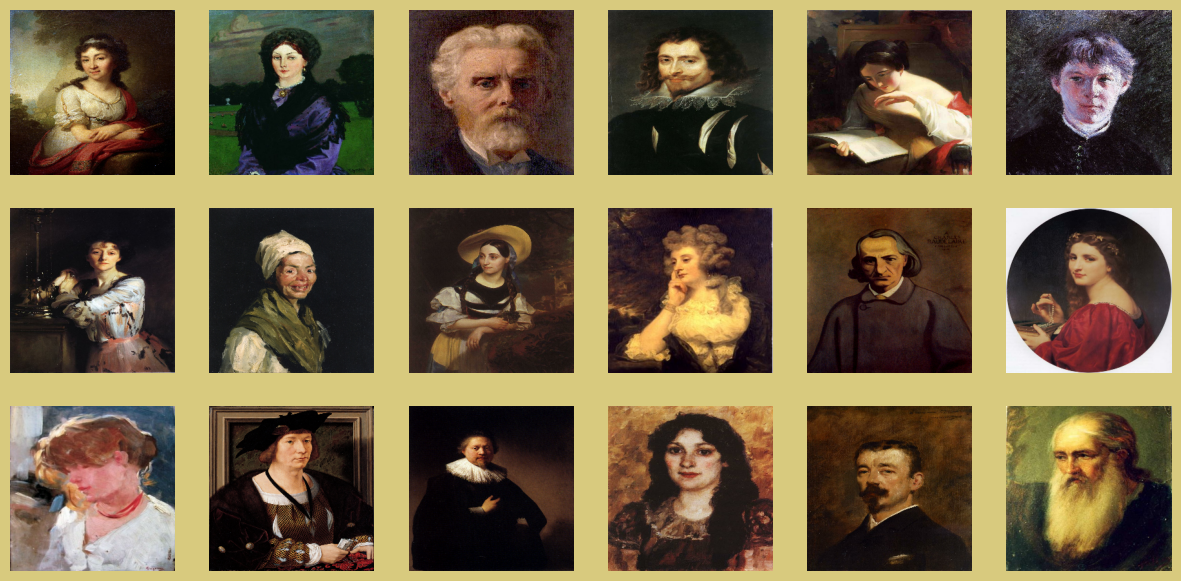

In [16]:
# Loading generated images
Generated_path = "./tmp"
Potraits_generated = tf.keras.preprocessing.image_dataset_from_directory(
    Generated_path, label_mode=None
)
# Plotting generated images
Show_Img(Potraits_generated)

## Conculsion

In the evaluation of the model: We can see that the GAN picked up the patterns in the portraits. It worked quite well. For further improvement,  as GANs are notorious for being data-hungry, I would consider increasing the dataset. There are many inconsistencies in the data which is rather complicated for the GAN to learn. Cleaning the data with some consistencies in the portrait styles would certainly help. Training it longer i.e. for more epochs would also help. Lastly, one can always strive to make a  more robust architecture for the Neural Networks.

# Acknowledgments

Thanks to [Karnika Kapoor](https://www.kaggle.com/karnikakapoor) for creating [art-by-gan](https://www.kaggle.com/code/karnikakapoor/art-by-gan). It inspires the majority of the content in this chapter.